In [1]:
import os
os.listdir()

['.ipynb_checkpoints', 'regression-notebook.ipynb']

In [2]:
import pandas as pd

df = pd.read_csv('../cereal.csv')

In [3]:
df

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193


In [4]:
df['total_carbo'] = df['carbo'] + df['sugars'] + df['fiber']

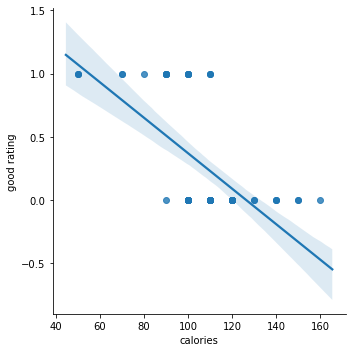

In [5]:
import seaborn as sns
%matplotlib inline

df['good rating'] = df['rating'] > 50
sns.lmplot(x='calories', y='good rating', data=df)

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
lr = LinearRegression()

In [8]:
# not bothering with train/test split since i'm not predicting out of sample

x = df[['fat']]
y = df['calories']

lr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

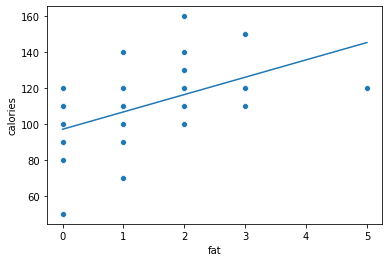

In [9]:
import matplotlib.pyplot as plt
import numpy as np

sns.scatterplot(x='fat', y='calories', data=df)
plt.plot([0, x.max().values[0]],
         [lr.predict(np.array([0]).reshape(1, -1)), lr.predict(x.max().values.reshape(1, -1))])

In [10]:
residuals = x.copy()
residuals['predicted'] = lr.predict(x['fat'].values.reshape(-1, 1))
residuals['actual'] = y
residuals['residuals'] = residuals['actual'] - residuals['predicted']

(array([ 3.,  2.,  1.,  6., 20., 23., 15.,  4.,  2.,  1.]),
 array([-47.10526316, -38.03576248, -28.96626181, -19.89676113,
        -10.82726046,  -1.75775978,   7.31174089,  16.38124157,
         25.45074224,  34.52024291,  43.58974359]),
 <a list of 10 Patch objects>)

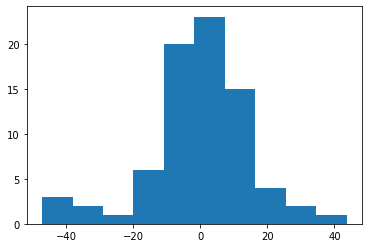

In [11]:
plt.hist(residuals['residuals'])

In [12]:
# that looks pretty normal to me :)

In [13]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(random_state=0)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# expecting that sodium and fiber have 0 coefficients; sugars, fiber and total_carbo have multicollinearity
x = df[['fat', 'total_carbo', 'protein', 'fiber', 'sodium', 'sugars']]
y = df['calories']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

params = {'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
          'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
          }

cv = GridSearchCV(enet, param_grid=params, n_jobs=-1)

cv.fit(train_x, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [15]:
cv.score(test_x, test_y)

0.9039270941880125

In [16]:
list(zip(x.columns, cv.best_estimator_.coef_))

[('fat', 8.007052026998904),
 ('total_carbo', 2.682756460183535),
 ('protein', 5.494509795461621),
 ('fiber', -4.047192894525656),
 ('sodium', -0.0024156072979363043),
 ('sugars', 0.4211101595165909)]

In [17]:
# without sugars
x = df[['fat', 'total_carbo', 'protein', 'fiber', 'sodium']]
y = df['calories']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

params = {'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
          'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
          }

cv = GridSearchCV(enet, param_grid=params, n_jobs=-1)

cv.fit(train_x, train_y)
cv.score(test_x, test_y)

0.9022098243570883

In [18]:
list(zip(x.columns, cv.best_estimator_.coef_))

[('fat', 8.652008844446078),
 ('total_carbo', 2.925610341592695),
 ('protein', 5.002673467337436),
 ('fiber', -4.043367992722977),
 ('sodium', -0.0067478762785116156)]

In [19]:
from sklearn.metrics import r2_score

# supposedly, the most accurate:
formula_calories = df['fat'] * 9 + df['protein'] * 4 + df['carbo'] * 4 + df['sugars'] * 4
r2_score(y, formula_calories)

0.7666708678429961

In [20]:
# and now without the 0 coef variable

# without sugars
x = df[['fat', 'total_carbo', 'protein', 'fiber']]
y = df['calories']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

lr = LinearRegression()
lr.fit(train_x, train_y)
lr.score(test_x, test_y)

0.9067546279320503

In [21]:
list(zip(x.columns, lr.coef_))

[('fat', 8.69092565145664),
 ('total_carbo', 2.8802897376370846),
 ('protein', 4.934497916978206),
 ('fiber', -3.9949271066462018)]

In [22]:
# very similar numbers :)